In [1]:
!pip install jieba
import pandas as pd
import jieba

# Load your CSV file
weibo_df = pd.read_csv('weibo_senti_100k_utf8_filtered_four_classes.csv')

jieba.load_userdict("emoji_slang.txt")

# Define a function to segment text
def segment_text(text):
    return ' '.join(jieba.cut(text, cut_all=False))

# Apply the text segmentation function to the 'review_cleaned' column
weibo_df['review_cutted_project'] = weibo_df['review_cleaned'].apply(segment_text)

# Save the DataFrame back to CSV
weibo_df.to_csv('weibo_senti_100k_utf8_filtered_four_classes_processed.csv', index=False)


Building prefix dict from the default dictionary ...
DEBUG:jieba:Building prefix dict from the default dictionary ...
Dumping model to file cache /tmp/jieba.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.cache
Loading model cost 0.593 seconds.
DEBUG:jieba:Loading model cost 0.593 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


In [2]:
weibo_df['review_cutted_project'][:10]

0         更博 了 爆照 了 帅 的 呀 就是 越来越 爱 你 生快 傻 缺爱 你 爱 你 爱 你
1      土耳其 的 事要 认真对待 哈哈 否则 直接 开除   很 是 细心 酒店 都 全部 OK 啦
2                                姑娘 都 羡慕 你 呢 还有 招财猫 高兴
3                                                 美爱 你
4                               梦想 有 多 大 舞台 就 有 多 大 鼓掌
5                                         花心 鼓掌   春暖花开
6    某 问答 社区 上 收到 一 大学生 发给 我 的 私信 偶 喜欢 阿姨 偶是 阿姨 控 我...
7    吃货 们 无不 啧啧称奇 好 不 喜欢 PS 写错 一个 字 哈哈                
8    Sweet   MorningFrom   now   onlove   yourselfe...
9    霍思燕 剖腹产 下小江江   老公 落泪 今晨 9 时 霍思燕 产下 一名 男婴 宝宝 重 ...
Name: review_cutted_project, dtype: object

In [3]:
!pip install tensorflow keras sklearn jieba
import jieba
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [4]:
# Load the data
df = pd.read_csv('weibo_senti_100k_utf8_filtered_four_classes_processed.csv')

# Segment text with jieba
df['review_cutted_project'] = df['review_cleaned'].apply(lambda x: ' '.join(jieba.cut(x)))

# Preprocessing (assuming the data is already loaded and balanced in df)
X = df['review_cutted_project'].astype(str)
y = df['sentiment_classified_four_classes']
# 1=positive 2=negative 3=Optimistic humorous 4=Pessimistic humorous
# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)

In [5]:
# Calculate max sequence length
max_seq_length = max([len(x) for x in X_seq])

X_pad = pad_sequences(X_seq, maxlen=max([len(x) for x in X_seq]))

# Encode class values
encoder = LabelEncoder()
encoder.fit(y)
y_enc = encoder.transform(y)
y_dummy = to_categorical(y_enc)

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_pad, y_dummy, test_size=0.2, random_state=42)

# Resampling with SMOTE
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


In [6]:
# Define the attention layer
class AttentionLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W = self.add_weight(name='attention_weight', shape=(input_shape[-1], 1), initializer='random_normal', trainable=True)
        self.b = self.add_weight(name='attention_bias', shape=(input_shape[1], 1), initializer='zeros', trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        # Alignment scores. Pass them through tanh function
        e = tf.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        # Remove dimension of size 1
        e = tf.keras.backend.squeeze(e, axis=-1)
        # Compute the weights
        alpha = tf.keras.backend.softmax(e)
        # Reshape to tensorFlow format
        alpha = tf.keras.backend.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = tf.keras.backend.sum(context, axis=1)
        return context, alpha

# Model definition with Attention
input_layer = Input(shape=(max_seq_length,))
embedding_layer = Embedding(len(tokenizer.word_index) + 1, output_dim=100, input_length=max_seq_length)(input_layer)
lstm_layer = Bidirectional(LSTM(64, return_sequences=True))(embedding_layer)

# Apply the attention layer
attention_output, attention_weights = AttentionLayer()(lstm_layer)
output_layer = Dense(4, activation='softmax')(attention_output)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 130)]             0         
                                                                 
 embedding (Embedding)       (None, 130, 100)          12470700  
                                                                 
 bidirectional (Bidirection  (None, 130, 128)          84480     
 al)                                                             
                                                                 
 attention_layer (Attention  ((None, 128),             258       
 Layer)                       (None, 130, 1))                    
                                                                 
 dense (Dense)               (None, 4)                 516       
                                                                 
Total params: 12555954 (47.90 MB)
Trainable params: 12555954 

In [7]:
# Model training
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1)
history = model.fit(X_train_resampled, y_train_resampled, epochs=5, batch_size=64, validation_split=0.1, callbacks=[early_stopping], verbose=1)

# Model evaluation
y_pred = model.predict(X_test).argmax(axis=1)
y_true = np.argmax(y_test, axis=1)

# Reverse transform from encoded labels to original labels
y_pred = encoder.inverse_transform(y_pred)
y_true = encoder.inverse_transform(y_true)

# Generate classification report
report = classification_report(y_true, y_pred, target_names=encoder.classes_.astype(str))
print(report)


Epoch 1/5
3049/3049 [==============================] - 1020s 333ms/step - loss: 1.0178 - accuracy: 0.5472 - val_loss: 1.4258 - val_accuracy: 0.0717
Epoch 2/5
3049/3049 [==============================] - 1068s 350ms/step - loss: 0.7747 - accuracy: 0.6546 - val_loss: 1.2840 - val_accuracy: 0.0818
Epoch 3/5
3049/3049 [==============================] - 1056s 346ms/step - loss: 0.6118 - accuracy: 0.7284 - val_loss: 1.4761 - val_accuracy: 0.1432
Epoch 4/5
3049/3049 [==============================] - 1022s 335ms/step - loss: 0.4543 - accuracy: 0.8021 - val_loss: 1.6496 - val_accuracy: 0.1690
Epoch 5/5
3049/3049 [==============================] - 1055s 346ms/step - loss: 0.3314 - accuracy: 0.8536 - val_loss: 2.0664 - val_accuracy: 0.2082
Epoch 5: early stopping
621/621 [==============================] - 19s 30ms/step
              precision    recall  f1-score   support

           1       0.91      0.83      0.87     13625
           2       0.68      0.80      0.73      4777
           3    

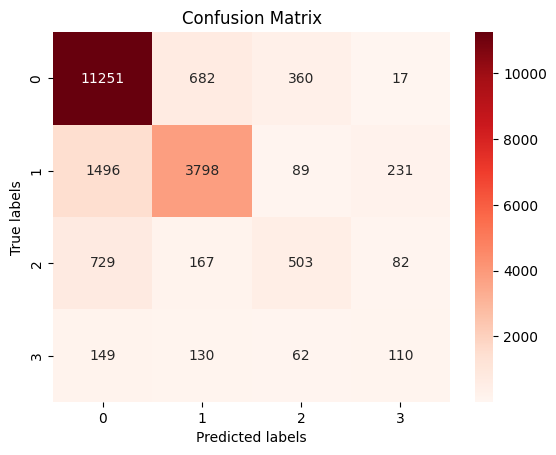

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_pred, y_true)

# Plot the confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Reds')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

